In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import math

In [3]:
Mft=yf.Ticker("MSFT")
Mft_his=Mft.history(start="2023-01-01",end="2024-01-01",interval='1h')

In [4]:
Mft_his

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-01-03 09:30:00-05:00,243.080002,245.750000,239.340103,239.788101,6337273,0.0,0.0
2023-01-03 10:30:00-05:00,239.800003,239.830002,237.500000,238.360001,3058832,0.0,0.0
2023-01-03 11:30:00-05:00,238.369995,238.690002,237.500000,238.150101,2236397,0.0,0.0
2023-01-03 12:30:00-05:00,238.179993,238.990005,237.399994,238.440002,2596124,0.0,0.0
2023-01-03 13:30:00-05:00,238.449997,238.949997,238.050003,238.550003,1635805,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-29 11:30:00-05:00,373.589996,374.640015,373.480011,373.690002,1239729,0.0,0.0
2023-12-29 12:30:00-05:00,373.690002,375.910004,373.630005,375.255005,1539466,0.0,0.0
2023-12-29 13:30:00-05:00,375.230011,376.500000,375.200012,376.043213,1260646,0.0,0.0


In [5]:
def stoch(obj, k_lookback, d_lookback):
  high,low,close=obj['High'], obj['Low'],obj['Close'],
  lowest_low = low.rolling(k_lookback).min()
  highest_high = high.rolling(k_lookback).max()
  k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
  d_line = k_line.rolling(d_lookback).mean()
  obj['%k']=k_line
  obj['%d']=d_line
  return obj

In [6]:
def BollingerBands(obj,wsize=20):
  roll_mean=obj['Close'].rolling(window=wsize).mean()
  roll_std=obj['Close'].rolling(window=wsize).std()
  obj['middleband']=roll_mean
  obj['upperband']=roll_mean+2*roll_std
  obj['lowerband']=roll_mean-2*roll_std
  return obj

In [7]:
def VPT(obj):
  obj['VROC']=0
  obj['VROC']=(obj['Volume']-obj['Volume'].shift(5))
  return obj

In [8]:
def creating_df(obj):
  obj=stoch(obj,14,3)
  obj=BollingerBands(obj)
  obj=VPT(obj)
  return obj

In [9]:
def strategy(obj):
  # (obj['RSI'][i]>70) &
    obj=creating_df(obj)
    Signals=[]
    flag=0#START FLAG
    obj['Signal']=0
    for i in range(len(obj)):
        if(i!=0):
    #Buying
            if(obj['Close'].iloc[i]<=(obj['lowerband'].iloc[i]) and obj['%k'].iloc[i-1]>30 and obj['%d'].iloc[i-1]>30 and obj['%k'].iloc[i]<30 and obj['%d'].iloc[i]<30 and obj['VROC'].iloc[i]>1):
                if(flag!=1):
                    buy=i
                    flag=1
                    obj['Signal'].iloc[i]=1
            #selling
            elif(  obj['Close'].iloc[i]>=(obj['upperband'].iloc[i]) and obj['%k'].iloc[i-1]<70 and obj['%d'].iloc[i-1]<70 and obj['%k'].iloc[i]>70 and obj['%d'].iloc[i]>70 and obj['VROC'].iloc[i]>1):
                if(flag!=-1):
                    sell=i
                    flag=-1
                    obj['Signal'].iloc[i]=-1

          #STOP LOSS TAKE PROFIT:
            if(flag==1 and obj['Close'].iloc[i]>1.1*obj['Close'].iloc[buy]):
              sell=i
              flag=-1
              obj['Signal'].iloc[i]=-1
            if(flag==1 and obj['Close'].iloc[i]<0.95*obj['Close'].iloc[buy]):
              sell=i
              flag=-1
              obj['Signal'].iloc[i]=-1
    return obj

In [20]:
def backtest(investment,obj):
    initial_invest=investment
    no_shares=0
    amt_left=0
    profits=[]
    returns=[]
    for i in range(len(obj['Signal'])):
        if obj['Signal'].iloc[i]==1:
            no_shares=math.floor(initial_invest/(obj['Close'].iloc[i]))
            amt_left=initial_invest-no_shares*obj['Close'].iloc[i]
        if obj['Signal'].iloc[i]==-1 and (no_shares!=0):
            profit=no_shares*obj['Close'].iloc[i]+amt_left-initial_invest
            profits.append(profit)
            return2=profit/initial_invest
            returns.append(return2)

    print(f'Profit gained from the BB STOCH strategy by investing in BITCOIN : {sum(profits)}')
    # print(f'Total Return is:{(sum(profits)/initial_invest)*100}')
    return1=(sum(profits)/initial_invest)
    returns=np.array(returns)
    returns = pd.Series(returns)
    annual_trading_days=252
    risk_free_rate=0.02
    num_years=4
    annualized_return=((1 + return1 )** (1 / num_years)) - 1
    portfolio_values=[initial_invest+profit1 for profit1 in profits]
    peak = portfolio_values[0]
    drawdown = 0
    for value in portfolio_values:
        peak = max(peak, value)
        drawdown = max(drawdown, (peak - value) / peak)
    max_drawdown=drawdown * 100
    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio=((avg_return - risk_free_rate) / std_dev)*np.sqrt(252)
    downside_returns = np.minimum(returns ,0)
    downside_deviation = np.std(downside_returns)
    avg_return = np.mean(returns)
    sortino_ratio=(avg_return)/ downside_deviation


    metrics = {
        'Total Return[%]' : return1 *100,
        'Annual Return[%]': annualized_return * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max. Drawdown [%]': max_drawdown,
    }

    # Print the metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    # print('Profit percentage of the BB STOCH strategy : {}%'.format(profit_percentage))

In [21]:
ans=strategy(Mft_his)
ans

<ipython-input-9-9b4ca0407fcb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['Signal'].iloc[i]=1
<ipython-input-9-9b4ca0407fcb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['Signal'].iloc[i]=-1
<ipython-input-9-9b4ca0407fcb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['Signal'].iloc[i]=1
<ipython-input-9-9b4ca0407fcb>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,Open,High,Low,Close,Volume,Dividends,Stock Splits,%k,%d,middleband,upperband,lowerband,VROC,Signal
Datetime,,,,,,,,,,,,,,
2023-01-03 09:30:00-05:00,243.080002,245.750000,239.340103,239.788101,6337273,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2023-01-03 10:30:00-05:00,239.800003,239.830002,237.500000,238.360001,3058832,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2023-01-03 11:30:00-05:00,238.369995,238.690002,237.500000,238.150101,2236397,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2023-01-03 12:30:00-05:00,238.179993,238.990005,237.399994,238.440002,2596124,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2023-01-03 13:30:00-05:00,238.449997,238.949997,238.050003,238.550003,1635805,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 11:30:00-05:00,373.589996,374.640015,373.480011,373.690002,1239729,0.0,0.0,17.381163,43.987395,374.571736,376.669245,372.474228,216162.0,0
2023-12-29 12:30:00-05:00,373.690002,375.910004,373.630005,375.255005,1539466,0.0,0.0,54.643018,29.405054,374.623236,376.735427,372.511045,84186.0,0
2023-12-29 13:30:00-05:00,375.230011,376.500000,375.200012,376.043213,1260646,0.0,0.0,73.409821,48.478001,374.693896,376.899528,372.488265,-1326859.0,0


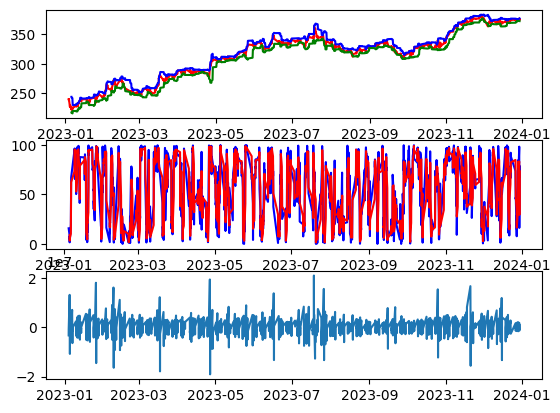

In [22]:
plt.subplot(3,1,1)
plt.plot(ans.index.values,ans['Close'],c='r')
plt.plot(ans.index.values,ans['upperband'],c='b')
plt.plot(ans.index.values,ans['lowerband'],c='g')


plt.subplot(3,1,2)
plt.plot(ans.index.values,ans['%k'],c='b')
plt.plot(ans.index.values,ans['%d'],c='r')

plt.subplot(3,1,3)
plt.plot(ans.index.values,ans['VROC'])


In [23]:
abs(ans['Signal']).sum()

7

In [24]:
backtest(100000,ans)

Profit gained from the BB STOCH strategy by investing in BITCOIN : 14453.791076660156
Total Return[%]: 14.45
Annual Return[%]: 3.43
Sharpe Ratio: 5.91
Sortino Ratio: 1.73
Max. Drawdown [%]: 14.49
